In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random
import pickle 
import matplotlib.pyplot as plt

def scrape_goodreads_ratings(user_id, max_pages=10):
    """
    Scrape a user's star ratings from Goodreads.
    
    Args:
    - user_id (str): Goodreads user ID or profile suffix.
    - max_pages (int): Maximum number of pages to scrape (each page contains ~30 books).
    
    Returns:
    - pd.DataFrame: A DataFrame containing book titles and ratings.
    """
    base_url = f"https://www.goodreads.com/review/list/{user_id}?shelf=read"
    headers = {"User-Agent": "Mozilla/5.0"}
    books = []

    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"Failed to fetch page {page}. Status code: {response.status_code}")
            break

        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find all book entries in the table
        rows = soup.find_all("tr", class_="bookalike review")
        if not rows:
            print("No more data found.")
            break

        for row in rows:
            try:
                title = row.find("td", class_="field title").a.text.strip()
                rating_element = row.find("td", class_="field rating")
                rating = rating_element.find("span", class_="staticStars").get("title", "No rating")
                stars = map_rating(rating)
                books.append({"Title": title, "Rating": stars, "User_id": user_id})
#                 print(title, rating, stars)
            except AttributeError:
                # Handle rows with missing data
                continue

        print(f"Page {page} scraped successfully.")
        time.sleep(random.uniform(1, 5))  # Be kind to the server and avoid being blocked

    # Return data as a pandas DataFrame
    return pd.DataFrame(books)



In [2]:
def map_rating(phrase):
    rating_map = {
        "liked it": 3,
        "really liked it": 4,
        "it was ok": 2, 
        "it was amazing": 5, 
        "did not like it": 1,
    }
    
    return rating_map.get(phrase, "Invalid rating")  # Default to "Invalid rating" if the phrase isn't in the dictionary


In [3]:
# if __name__ == "__main__":
# #     user_id = "6688207"  # Replace with the Goodreads user ID or profile suffix
# #     for user_id in tqdm(['30181442', '75009563', '11345366', '110912303', '113964939', '11215896', '53701594', '4622890', '93628736', '176180116']):
# #     for user_id in tqdm(['2974095', '4622890', '28953843', '16174645', '4159922', '4125660', '54886546', '16912659', '260116', '4685500', '21865425']):
# #     for user_id in tqdm(['53701594', '27709782', '7566229', '16652861', '30817744', '56259255', '4125660', '60964126', 
# #                          '176167767', '28510930', '1029975', '131020767', '28862120', '88713906', '160141433', '41097916', 
# #                          '20809863', '69519261', '24017481', '7376365', '75941333', '13571407', '106618742', '17792052',
# #                          '3534528', '130656897', '7474475', '4125412', '6336365', '6026811', '3438047']):
#     for user_id in ['169695556']:
#         print("User_id = ", user_id)
#         max_pages = 30  # Adjust based on expected data
#         ratings_data = scrape_goodreads_ratings(user_id, max_pages)

#         if not ratings_data.empty:
# #             print(ratings_data.head())
# #             ratings_data.to_csv("goodreads_ratings.csv", index=False)
#             ratings_data.to_csv('goodreads_ratings.csv', mode='a', header=False, index=False)
#             print("Data saved to goodreads_ratings.csv.")
#         else:
#             print("No data retrieved.")


In [4]:
df = pd.read_csv('goodreads_ratings.csv')
print(df.shape)
df = df.drop_duplicates()
print(df.shape)
# Print the entire DataFrame
print(df)

duplicate_count = df['Title'].duplicated().sum()
# print("Number of books with at least two people rating it:", duplicate_count)
duplicate_counts_per_value = df['Title'].value_counts()
print(duplicate_counts_per_value)
print("Number of unique books: ", df['Title'].nunique())
num_users = df['User_id'].nunique()
user_ids = list(df['User_id'].unique())
print("number of users is: ", num_users)
# print("user_ids = ", user_ids)

(296372, 3)
(284940, 3)
                                                    Title Rating    User_id
0                                       I Am Watching You      3  169695558
1       Three to Get Deadly\n        (Stephanie Plum, #3)      3  169695558
2       Before the Coffee Gets Cold\n        (Before t...      4  169695558
3       Dark Sacred Night\n        (Renée Ballard, #2;...      4  169695558
4         Two for the Dough\n        (Stephanie Plum, #2)      4  169695558
...                                                   ...    ...        ...
296367        Heir of Fire\n        (Throne of Glass, #3)      5  127541816
296368           Six of Crows\n        (Six of Crows, #1)      5  127541816
296369  A Court of Mist and Fury\n        (A Court of ...      5  127541816
296370  The Cruel Prince\n        (The Folk of the Air...      5  127541816
296371  Harry Potter and the Sorcerer's Stone\n       ...      5  127541816

[284940 rows x 3 columns]
Harry Potter and the Sorcerer's Stone

In [5]:
df['Series'] = df['Title'].str.contains('\n', case=False)
df['First'] = df['Title'].str.contains(r"#1\)", case=False) & df['Series']
# active_rows = df[df['Active']]
# print(df[df['First']])

df['Suggest'] = (df['Series'] == False) | (df['First'] == True)
print(df)

df.to_csv("goodreads_ratings_series.csv", index=False)

# with open("suggest.pkl", "wb") as file:
#     pickle.dump(list(df['Suggest']), file)

                                                    Title Rating    User_id  \
0                                       I Am Watching You      3  169695558   
1       Three to Get Deadly\n        (Stephanie Plum, #3)      3  169695558   
2       Before the Coffee Gets Cold\n        (Before t...      4  169695558   
3       Dark Sacred Night\n        (Renée Ballard, #2;...      4  169695558   
4         Two for the Dough\n        (Stephanie Plum, #2)      4  169695558   
...                                                   ...    ...        ...   
296367        Heir of Fire\n        (Throne of Glass, #3)      5  127541816   
296368           Six of Crows\n        (Six of Crows, #1)      5  127541816   
296369  A Court of Mist and Fury\n        (A Court of ...      5  127541816   
296370  The Cruel Prince\n        (The Folk of the Air...      5  127541816   
296371  Harry Potter and the Sorcerer's Stone\n       ...      5  127541816   

       Series  First  Suggest  
0       False  Fals

In [6]:
# Get a list of top titles in order
top_titles = duplicate_counts_per_value.index.tolist()
top_100 = top_titles[:1000]

for title in top_100:
    print(title)
    
# with open("top_100.pkl", "wb") as file:
#     pickle.dump(top_100, file)

Harry Potter and the Sorcerer's Stone
        (Harry Potter, #1)
The Hunger Games
        (The Hunger Games, #1)
To Kill a Mockingbird
Twilight
        (The Twilight Saga, #1)
The Great Gatsby
The Catcher in the Rye
Harry Potter and the Prisoner of Azkaban
        (Harry Potter, #3)
1984
Animal Farm
Harry Potter and the Chamber of Secrets
        (Harry Potter, #2)
The Hobbit, or There and Back Again
        (The Lord of the Rings, #0)
Pride and Prejudice
Harry Potter and the Deathly Hallows
        (Harry Potter, #7)
Harry Potter and the Goblet of Fire
        (Harry Potter, #4)
Harry Potter and the Half-Blood Prince
        (Harry Potter, #6)
Lord of the Flies
The Kite Runner
Harry Potter and the Order of the Phoenix
        (Harry Potter, #5)
Romeo and Juliet
Catching Fire
        (The Hunger Games, #2)
The da Vinci Code
        (Robert Langdon, #2)
Mockingjay
        (The Hunger Games, #3)
The Diary of a Young Girl
The Help
Of Mice and Men
The Lovely Bones
The Alchemist
The Girl wi

In [7]:
for index, value in duplicate_counts_per_value.iteritems():
    if value > 5:
        print(round(value/num_users*100, 1), index)
# print(type(duplicate_counts_per_value))



18.6 Harry Potter and the Sorcerer's Stone
        (Harry Potter, #1)
16.5 The Hunger Games
        (The Hunger Games, #1)
16.4 To Kill a Mockingbird
15.3 Twilight
        (The Twilight Saga, #1)
14.1 The Great Gatsby
12.1 The Catcher in the Rye
10.9 Harry Potter and the Prisoner of Azkaban
        (Harry Potter, #3)
10.9 1984
10.7 Animal Farm
10.6 Harry Potter and the Chamber of Secrets
        (Harry Potter, #2)
10.4 The Hobbit, or There and Back Again
        (The Lord of the Rings, #0)
10.4 Pride and Prejudice
10.4 Harry Potter and the Deathly Hallows
        (Harry Potter, #7)
10.2 Harry Potter and the Goblet of Fire
        (Harry Potter, #4)
9.9 Harry Potter and the Half-Blood Prince
        (Harry Potter, #6)
9.9 Lord of the Flies
9.7 The Kite Runner
9.6 Harry Potter and the Order of the Phoenix
        (Harry Potter, #5)
9.6 Romeo and Juliet
9.6 Catching Fire
        (The Hunger Games, #2)
9.5 The da Vinci Code
        (Robert Langdon, #2)
9.0 Mockingjay
        (The Hunger Ga

/tmp/ipykernel_3369/986463553.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in duplicate_counts_per_value.iteritems():


Frankenstein
4.8 The Odyssey
4.7 A Court of Thorns and Roses
        (A Court of Thorns and Roses, #1)
4.7 Verity
4.5 Eragon
        (The Inheritance Cycle, #1)
4.4 The Little Prince
4.3 A Tale of Two Cities
4.2 The Silent Patient
4.1 Gone with the Wind
4.1 A Thousand Splendid Suns
4.1 The Golden Compass
        (His Dark Materials, #1)
4.1 The Shining
        (The Shining, #1)
4.1 All the Light We Cannot See
4.1 Charlotteâ€™s Web
4.0 The Count of Monte Cristo
4.0 The Glass Castle
4.0 Dune
        (Dune, #1)
4.0 One Hundred Years of Solitude
3.9 Educated
3.9 The Giving Tree
3.9 The Midnight Library
3.9 The Poisonwood Bible
3.8 Fourth Wing
        (The Empyrean, #1)
3.7 A Time to Kill
        (Jake Brigance, #1)
3.7 The Perks of Being a Wallflower
3.7 The Nightingale
3.7 The Outsiders
3.6 Night
        (The Night Trilogy, #1)
3.6 Outlander
        (Outlander, #1)
3.6 Sense and Sensibility
3.5 The Girl Who Played with Fire
        (Millennium, #2)
3.5 The Picture of Dorian Gray
3.5 Into 

1.1 Charlotte’s Web
1.1 Anansi Boys
1.1 The Night She Disappeared
1.1 Drums of Autumn
        (Outlander, #4)
1.1 Peter Pan
1.1 The Way of Kings
        (The Stormlight Archive, #1)
1.1 The Undomestic Goddess
1.1 Sheâ€™s Come Undone
1.1 King Lear
1.1 Kafka on the Shore
1.1 Go Ask Alice
1.1 The Tales of Beedle the Bard
        (Hogwarts Library, #3)
1.1 The Mark of Athena
        (The Heroes of Olympus, #3)
1.1 Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life...
1.1 Needful Things
1.1 Winter Garden
1.0 From Dead to Worse
        (Sookie Stackhouse, #8)
1.0 State of Wonder
1.0 Wish You Were Here
1.0 The Storyteller
1.0 The World According to Garp
1.0 The Phantom Tollbooth
1.0 On Writing: A Memoir of the Craft
1.0 The Good Sister
1.0 The Brothers Karamazov
1.0 American Gods
1.0 Mexican Gothic
1.0 Jonathan Livingston Seagull
1.0 Shadow Kiss
        (Vampire Academy, #3)
1.0 The War of the Worlds
1.0 The Serpent and the Wings of Night
        (Crowns of 

0.6 The Audacity of Hope: Thoughts on Reclaiming the American Dream
0.6 Between Shades of Gray
0.6 The Happy Ever After Playlist
        (The Friend Zone, #2)
0.6 The Dinner
0.6 In a Holidaze
0.6 Reflected in You
        (Crossfire, #2)
0.6 Cruel Winter with You
        (Under the Mistletoe Collection, #1)
0.6 The Overstory
0.6 I Am Watching You
0.6 Evvie Drake Starts Over
0.6 All Systems Red
        (The Murderbot Diaries, #1)
0.6 The Miserable Mill
        (A Series of Unfortunate Events, #4)
0.6 The Blade Itself
        (The First Law, #1)
0.6 A Wind in the Door
        (Time Quintet, #2)
0.6 Salt to the Sea
0.6 The Princess Diaries
        (The Princess Diaries, #1)
0.6 The Book of Cold Cases
0.6 The Art of Fielding
0.6 Eye of the Needle
0.6 Elantris
        (Elantris, #1)
0.6 Behind the Beautiful Forevers: Life, Death, and Hope in a Mumbai Undercity
0.6 The Power of Now: A Guide to Spiritual Enlightenment
0.6 The Midnight Feast
0.6 The Story of a New Name
        (Neapolitan Novel

0.4 The Lost World
        (Jurassic Park, #2)
0.4 The Exiles
0.4 Last Argument of Kings
        (The First Law, #3)
0.4 Restore Me
        (Shatter Me, #4)
0.4 The Bridge Kingdom
        (The Bridge Kingdom, #1)
0.4 Done and Dusted
        (Rebel Blue Ranch, #1)
0.4 Mostly Harmless
        (Hitchhiker's Guide to the Galaxy, #5)
0.4 The Beekeeper of Aleppo
0.4 Eats, Shoots & Leaves: The Zero Tolerance Approach to Punctuation
0.4 A Wild Sheep Chase
        (The Rat, #3)
0.4 Gone Tomorrow
        (Jack Reacher, #13)
0.4 I Am America
0.4 Miracle Creek
0.4 House of Leaves
0.4 Hawaii
0.4 After
        (After, #1)
0.4 Sputnik Sweetheart
0.4 The Orphan Master's Son
0.4 Caleb's Crossing
0.4 In Defense of Food: An Eater's Manifesto
0.4 The Life and Times of the Thunderbolt Kid
0.4 Before We Were Strangers
0.4 The Therapist
0.4 The Boleyn Inheritance
        (The Plantagenet and Tudor Novels, #10)
0.4 A Dirty Job
        (Grim Reaper, #1)
0.4 The Essex Serpent
0.4 Magic Bites
        (Kate Danie

0.3 The Scorpio Races
0.3 The Chosen
        (Reuven Malther, #1)
0.3 The Handmaid's Tale
        (The Handmaid's Tale, #1)
0.3 Night Embrace
        (Dark-Hunter, #2)
0.3 The Forest of Vanishing Stars
0.3 Counting the Cost
0.3 The Mammoth Hunters
        (Earth's Children, #3)
0.3 Soulless
        (Parasol Protectorate, #1)
0.3 The Opal Deception
        (Artemis Fowl, #4)
0.3 The Awakening / The Struggle
        (The Vampire Diaries, #1-2)
0.3 Keeping 13
        (Boys of Tommen, #2)
0.3 When She Returned
0.3 The Stolen Heir
        (The Stolen Heir Duology, #1)
0.3 The Aviator's Wife
0.3 Better Homes and Gardens New Cook Book
0.3 Reasons to Stay Alive
0.3 Shadow's Edge
        (Night Angel, #2)
0.3 M is for Malice
        (Kinsey Millhone, #13)
0.3 On Chesil Beach
0.3 The Last Unicorn
        (The Last Unicorn, #1)
0.3 Fairest
        (The Lunar Chronicles, #3.5)
0.3 Dorothy Must Die
        (Dorothy Must Die, #1)
0.3 Iona Iverson's Rules for Commuting
0.3 The Winter People
0.3 The O

0.3 The Coldest Girl in Coldtown
0.3 The Storyteller's Secret
0.3 Switched
        (Trylle, #1)
0.3 Who Do You Love
0.3 Sweet Tooth
0.3 Beyond the Wand: The Magic & Mayhem of Growing Up a Wizard
0.3 Stuck with You
        (The STEMinist Novellas, #2)
0.3 The Goal: A Process of Ongoing Improvement
0.3 The Sisters Brothers
0.3 Rita Hayworth and Shawshank Redemption
0.3 Long Walk to Freedom
0.3 Binti
        (Binti, #1)
0.3 The Castaways
        (Nantucket, #2)
0.3 The Body in the Library
        (Miss Marple, #2)
0.3 Angels Flight
        (Harry Bosch, #6; Harry Bosch Universe, #8)
0.3 Need
        (Need, #1)
0.3 The Demon King
        (Seven Realms, #1)
0.3 The Bride Test
        (The Kiss Quotient, #2)
0.3 Blueberries for Sal
0.3 The Hiding Place
0.3 A Mercy
0.3 Fangirl Down
        (Big Shots, #1)
0.3 The Enchanted
0.3 Saving 6
        (Boys of Tommen, #3)
0.3 Foe
0.3 The Diamond Age: Or, a Young Lady's Illustrated Primer
0.3 A Year in Provence
        (Provence, #1)
0.3 The Nanny
0.3

0.3 A Hat Full of Sky
        (Discworld, #32; Tiffany Aching, #2)
0.3 Even Cowgirls Get the Blues
0.3 Saga, Volume 2
0.3 The Darkest Night
        (Lords of the Underworld, #1)
0.3 Muse of Nightmares
        (Strange the Dreamer, #2)
0.3 Will
0.3 Catching Fire
        (Hunger Games, #2)
0.3 Lie to Me
0.3 Witch & Wizard
        (Witch & Wizard, #1)
0.3 Anne of Ingleside
        (Anne of Green Gables, #6)
0.3 The Chase
        (Briar U, #1)
0.3 The Mayor of Casterbridge
0.3 The Off Limits Rule
        (It Happened in Nashville, #1)
0.3 Shadows of Self
        (Mistborn, #5)
0.3 Jingo
        (Discworld, #21; City Watch, #4)
0.3 I Hope This Finds You Well
0.3 The End
        (A Series of Unfortunate Events, #13)
0.3 Rilla of Ingleside
        (Anne of Green Gables, #8)
0.3 Lords and Ladies
        (Discworld, #14; Witches, #4)
0.3 Think Again: The Power of Knowing What You Don't Know
0.3 The Kiss of Deception
        (The Remnant Chronicles, #1)
0.3 The Magician's Assistant
0.3 Lock In
 

0.3 The Elements of Style
0.3 Deep Work: Rules for Focused Success in a Distracted World
0.3 Eleanor and Park
0.3 Turbo Twenty-Three
        (Stephanie Plum, #23)
0.3 The Predator
        (Dark Verse, #1)
0.3 Kane & Abel
        (Kane & Abel, #1)
0.3 Nausea
0.3 Way of the Peaceful Warrior: A Book That Changes Lives
0.3 The Mountains Sing
0.3 The 48 Laws of Power
0.3 Knowing God
0.3 Micah
        (Anita Blake, Vampire Hunter, #13)
0.3 The Tenant of Wildfell Hall
0.3 Taltos
        (Lives of the Mayfair Witches, #3)
0.3 Out of the Silent Planet
        (The Space Trilogy, #1)
0.3 Fool
0.3 Cerulean Sins
        (Anita Blake, Vampire Hunter, #11)
0.3 My Life Next Door
0.3 Love & Gelato
        (Love & Gelato, #1)
0.3 Boy: Tales of Childhood
        (Roald Dahl's Autobiography, #1)
0.3 My Darling Husband
0.3 Chasing Fire
0.2 The Ritual
        (L.O.R.D.S., #1)
0.2 Y: The Last Man, Vol. 5: Ring of Truth
0.2 Cheaper by the Dozen
0.2 The Most Dangerous Game
0.2 Who Is Maud Dixon?
0.2 Mary, Mar

0.2 A Merry Little Meet Cute
0.2 The Candy House
0.2 The Hunter
        (Cal Hooper, #2)
0.2 Paris for One and Other Stories
0.2 Bastard Out of Carolina
0.2 The Alexandria Link
        (Cotton Malone, #2)
0.2 Enclave
        (Razorland, #1)
0.2 Bel-Ami
0.2 Memoirs of a Teenage Amnesiac
0.2 The Herd
0.2 Same Kind of Different as Me: A Modern-Day Slave, an International Art Dealer, and the Unlikely Woman Who Bound Them Together
0.2 The People of Sparks
        (Book of Ember, #2)
0.2 Every Vow You Break
0.2 Pleasure of a Dark Prince
        (Immortals After Dark, #8)
0.2 My Heart and Other Black Holes
0.2 Harry Potter Boxed Set, Books 1-5
        (Harry Potter, #1-5)
0.2 The Known World
0.2 The American Heiress
0.2 Stone Cold Fox
0.2 The Patient's Secret
0.2 Interior Chinatown
0.2 Real Murders
        (Aurora Teagarden, #1)
0.2 Physik
        (Septimus Heap, #3)
0.2 The Crossing Places
        (Ruth Galloway, #1)
0.2 The Story of Arthur Truluv
        (Mason, #1)
0.2 By the Book
        

0.2 Narrative of the Life of Frederick Douglass
0.2 The Gilded Cage
        (The Prison Healer, #2)
0.2 The Guncle
0.2 Fantastic Beasts and Where to Find Them: The Original Screenplay
        (Fantastic Beasts: The Original Screenplay, #1)
0.2 Out of the Easy
0.2 Creation Lake
0.2 Being Henry: The Fonz . . . and Beyond
0.2 Nevermoor: The Trials of Morrigan Crow
        (Nevermoor, #1)
0.2 The Reappearance of Rachel Price
0.2 Cockroaches
        (Harry Hole, #2)
0.2 The Starfish Sisters
0.2 The Stolen Child
0.2 War
0.2 Lost and Lassoed
        (Rebel Blue Ranch, #3)
0.2 Seventh Son
        (Tales of Alvin Maker, #1)
0.2 Angel Falls
0.2 Murder in Mesopotamia
        (Hercule Poirot, #14)
0.2 The Rule of Four
0.2 Y: The Last Man, Vol. 2: Cycles
0.2 Black Hole
0.2 Shelter
0.2 Midnight at the Blackbird CafÃ©
0.2 Bearing an Hourglass
        (Incarnations of Immortality, #2)
0.2 The Quickie
0.2 Anya's Ghost
0.2 Full Moon Rising
        (Riley Jenson Guardian, #1)
0.2 When the Wind Blows
    

0.2 Under Currents
0.2 My Losing Season: A Memoir
0.2 Sail
0.2 SantaLand Diaries
0.2 The Street
0.2 Malice
        (The Faithful and the Fallen, #1)
0.2 The Kingmaker's Daughter
        (The Plantagenet and Tudor Novels, #4; Cousins War, #4)
0.2 In the Kingdom of Ice: The Grand and Terrible Polar Voyage of the USS Jeannette
0.2 Unbelievable: My Front-Row Seat to the Craziest Campaign in American History
0.2 The Code Book: The Science of Secrecy from Ancient Egypt to Quantum Cryptography
0.2 Bloody Heart
        (Brutal Birthright, #4)
0.2 Prisoners of Geography: Ten Maps That Tell You Everything You Need to Know About Global Politics
0.2 The Wrong Bride
        (The Windsors, #1)
0.2 Happy Ever After
        (Bride Quartet, #4)
0.2 In Order to Live: A North Korean Girl's Journey to Freedom
0.2 The Call of Cthulhu
0.2 We the Animals
0.2 Heavy
0.2 Exodus
        (The Ravenhood, #2)
0.2 A Little Ray of Sunshine
0.2 We Are Not Ourselves
0.2 Influence: The Psychology of Persuasion
0.2 God o

0.2 The Curse of Chalion
        (World of the Five Gods, #1)
0.2 The Undertaking of Hart and Mercy
        (Hart and Mercy, #1)
0.2 Fool's Assassin
        (The Fitz and the Fool, #1)
0.2 Madame Tussaud: A Novel of the French Revolution
0.2 A Very Merry Bromance
        (Bromance Book Club, #5)
0.2 Call the Canaries Home
0.2 Radiance
        (Wraith Kings, #1)
0.2 Finding Audrey
0.2 Lucy
0.2 Hissy Fit
0.2 From Here to Eternity: Traveling the World to Find the Good Death
0.2 Archangel's Kiss
        (Guild Hunter, #2)
0.2 Fire & Blood
        (A Targaryen History, #1)
0.2 Somewhere Beyond the Sea
        (Cerulean Chronicles, #2)
0.2 The All-Girl Filling Station's Last Reunion
0.2 Tai-Pan
        (Asian Saga, #2)
0.2 The Winter of Our Discontent
0.2 The Salt Path
0.2 Kidnapped
        (David Balfour, #1)
0.2 I Contain Multitudes: The Microbes Within Us and a Grander View of Life
0.2 Portrait of a Killer: Jack the Ripper - Case Closed
0.2 I Am Charlotte Simmons
0.2 Not a Fan: Becoming a

        (Amgash #1)
0.2 Everyone Brave Is Forgiven
0.2 The Proper Care and Feeding of Husbands
0.2 Everybody's Fool
        (Sully, #2)
0.2 The Summer Guest
0.2 You, Again
0.2 Lovely War
0.2 Since We Fell
0.2 The Word is Murder
        (Hawthorne & Horowitz #1)
0.2 The Cat's Table
0.2 The Beach Club
0.2 A Boy and His Dog at the End of the World
0.2 King of the Murgos
        (The Malloreon, #2)
0.2 The Janus Stone
        (Ruth Galloway, #2)
0.2 The Yellow Bird Sings
0.2 So That Happened
        (Donovan Family #1)
0.2 Look on the Bright Side
0.2 All Clear
        (All Clear, #2)
0.2 Runaway Love
        (Cherry Tree Harbor, #1)
0.2 A Million Miles in a Thousand Years: What I Learned While Editing My Life
0.2 The Guest Book
0.2 True Believer
        (Terminal List, #2)
0.2 Deadhouse Gates
        (Malazan Book of the Fallen, #2)
0.2 Those Girls
0.2 The Shepherd's Crown
        (Discworld, #41; Tiffany Aching, #5)
0.2 Heartbreak Bay
        (Stillhouse Lake, #5)
0.2 Bitter Falls
       

0.2 Ask and It Is Given: Learning to Manifest Your Desires
0.2 Private Peaceful
0.2 Leven Thumps and the Gateway to Foo
        (Leven Thumps, #1)
0.2 Club Shadowlands
        (Masters of the Shadowlands, #1)
0.2 Heist Society
        (Heist Society, #1)
0.2 The Chrysalids
0.2 Only the Good Spy Young
        (Gallagher Girls, #4)
0.2 Generation X: Tales for an Accelerated Culture
0.2 The Price of Salt
0.2 The Time Traveler’s Wife
0.2 Sister Carrie
0.2 Island
0.2 God of Ruin
        (Legacy of Gods, #4)
0.2 All of Us Villains
        (All of Us Villains, #1)
0.2 #Girlboss
0.2 Only Human
        (Themis Files, #3)
0.2 Lysistrata
0.2 The Mastery of Love: A Practical Guide to the Art of Relationship: A Toltec Wisdom Book
0.2 Forbidden
0.2 The Miracle of Mindfulness: An Introduction to the Practice of Meditation
0.2 How the Irish Saved Civilization: The Untold Story of Ireland's Heroic Role from the Fall of Rome to the Rise of Medieval Europe
0.2 A Hidden Fire
        (Elemental Mysteries, 

In [40]:
# Convert 'rating' to numeric, forcing invalid values to NaN
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

# Remove rows where 'rating' is NaN
df = df.dropna(subset=["Rating"]).reset_index(drop=True)

# Group by title to find count and average rating
result = df.groupby("Title").agg(
    count=("Title", "size"),
    avg_rating=("Rating", "mean")
).reset_index()

# Display the result
# print(result[:10])
filtered_results = result[result["count"] > 10]
print("Number of books = ", len(filtered_results))
pd.set_option("display.max_rows", None)  # Show all rows
# print(filtered_results.sort_values(by="avg_rating", ascending=False))
# for row in result.iteritems():
#     print(row)

# with open("ave_ratings.pkl", "wb") as file:
#     pickle.dump(filtered_results, file)

for title in titles:
    if title not in result["Title"].values:
        print(title)

Number of books =  2903


Something in the Water


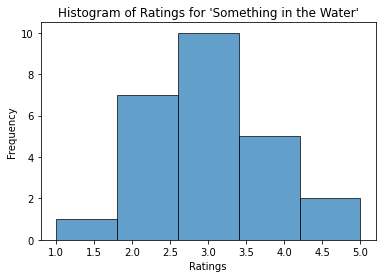

In [21]:
# Choose a title
selected_title = filtered_results["Title"][58689]
print(selected_title)

# Filter DataFrame for the selected title
filtered_df = df[df["Title"] == selected_title]

# Plot histogram of ratings
plt.hist(filtered_df["Rating"], bins=5, edgecolor="black", alpha=0.7)
plt.title(f"Histogram of Ratings for '{selected_title}'")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

In [14]:
# threshold = 10#num_users * 0.1
# pop_titles = list(duplicate_counts_per_value[duplicate_counts_per_value > threshold].index)
# my_titles = df.loc[df["User_id"] == 169695558, "Title"].tolist()
# # print(my_titles)

# print("pop titles len = ", len(pop_titles))
# # print(pop_titles)
# print("my titles len = ", len(my_titles))
# titles = list(set(pop_titles))# + my_titles))

#load the titles, 
with open("titles.pkl", "rb") as file:
    titles = pickle.load(file)
    
#If I need to filter out any titles, like box sets
# # print(titles)
# print("titles = ", len(titles))
# filtered_titles = [title for title in titles if "holy bible" not in title.lower()]
# print("filtered_titles = ", len(filtered_titles))
# # print(filtered_titles)
# with open("titles.pkl", "wb") as file:
#     pickle.dump(filtered_titles, file)


# #remove Harry Potter titles:
# titles = [s for s in titles if "Harry Potter" not in s]

num_titles = len(titles)


# print(titles)
# print(titles)
print("num_titles =", num_titles)

# ratings = np.full((num_users, num_titles), None)
ratings = np.zeros((num_users, num_titles))

for index, row in df.iterrows():
    if row['Title'] in titles:
        try:
            ratings[user_ids.index(row['User_id']), titles.index(row["Title"])] = int(row["Rating"])
#             print("found ", row["Title"])
        except:
            pass
        
print("ratings size = ", ratings.shape)
ratings = ratings[~np.all(ratings == 0, axis=1)]
print("ratings size = ", ratings.shape)
# Save the list to a file
# with open("titles.pkl", "wb") as file:
#     pickle.dump(titles, file)
    
    

# df['Series'] = df['Title'].str.contains('\n', case=False)
# df['First'] = df['Title'].str.contains('#1', case=False) & df['Series']
# # active_rows = df[df['Active']]
# # print(df[df['First']])

# df['Suggest'] = (df['Series'] == False) | (df['First'] == True)
# print(df)

# df.to_csv("goodreads_ratings_series.csv", index=False)



num_titles = 3023
ratings size =  (3748, 3023)
ratings size =  (2553, 3023)


In [43]:
# Map the average ratings based on the title list
average_ratings_list = [result.set_index("Title").loc[title, "avg_rating"] for title in titles]

# Print the resulting list of average ratings
print(average_ratings_list)

with open("average_ratings_list.pkl", "wb") as file:
    pickle.dump(average_ratings_list, file)

[3.642857142857143, 4.0, 4.464285714285714, 3.5428571428571427, 3.9, 4.295081967213115, 4.15, 3.8947368421052633, 3.5, 4.0, 4.081081081081081, 3.56, 3.8666666666666667, 4.0, 3.5, 4.209302325581396, 4.114285714285714, 3.8333333333333335, 3.9473684210526314, 4.558139534883721, 4.407079646017699, 4.188679245283019, 4.136363636363637, 3.7777777777777777, 4.083333333333333, 3.6875, 3.25, 3.92, 3.6666666666666665, 3.769230769230769, 4.051282051282051, 3.5454545454545454, 3.75, 4.375, 4.75, 3.727272727272727, 3.75, 4.5, 4.125, 3.8181818181818183, 3.7222222222222223, 3.5384615384615383, 3.5454545454545454, 3.71875, 4.181818181818182, 3.6818181818181817, 4.4, 3.26, 4.542857142857143, 3.9565217391304346, 4.478260869565218, 3.909090909090909, 4.818181818181818, 4.448275862068965, 4.220588235294118, 3.5384615384615383, 4.583333333333333, 3.6666666666666665, 3.4285714285714284, 4.04, 4.2, 4.315789473684211, 4.181818181818182, 2.8333333333333335, 3.5, 4.166666666666667, 3.4545454545454546, 3.4, 3.23

In [15]:
# #make suggest list 
# suggest = [True] * len(titles)
# for i, this in enumerate(titles):
#     if '\n' in this:
#         if "#1" not in this:
#             suggest[i] = False
        
# # for i in range(len(suggest)):        
# #     print(titles[i], suggest[i])
    
# with open("suggest.pkl", "wb") as file:
#     pickle.dump(suggest, file)

In [16]:
ratings_df = pd.DataFrame(ratings)
print(ratings_df.shape)
#delete users that don't have any of these ratings
# ratings_df = ratings_df.loc[~(ratings_df == 0).all(axis=1)]
ratings_df = ratings_df.loc[(ratings_df != 0).sum(axis=1) >= 5] #need at least 4 entries to stay
print(ratings_df.shape)

# Calculate percentage of non-zero elements
percentage_nonzero = (np.count_nonzero(ratings_df) / ratings_df.size) * 100
print("percentage_nonzero =", round(percentage_nonzero, 1), '%')

# Save the list to a file
with open("ratings_df.pkl", "wb") as file:
    pickle.dump(ratings_df, file)

(2553, 3023)
(1864, 3023)
percentage_nonzero = 1.6 %


Text(0, 0.5, 'Readers')

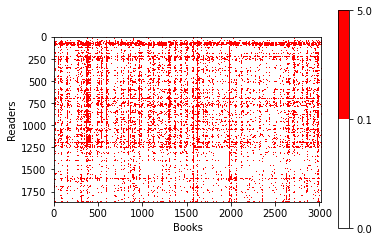

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap with white, yellow, and red
cmap = mcolors.ListedColormap(['white', 'red'])
bounds = [0, 0.1, 5]  # Define ranges: 0 (white), 0.1-0.5 (yellow), 0.5-1 (red)
norm = mcolors.BoundaryNorm(bounds, len(cmap.colors))

plt.imshow(ratings_df, cmap=cmap, norm=norm)
plt.colorbar()
plt.xlabel("Books")
plt.ylabel("Readers")

Text(0, 0.5, 'Number of books')

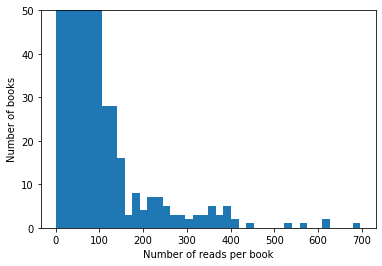

In [18]:
plt.hist(duplicate_counts_per_value, bins = 40)
plt.ylim([0,50])
plt.xlabel('Number of reads per book')
plt.ylabel("Number of books")
# print(duplicate_counts_per_value)

Text(0, 0.5, 'Number of users')

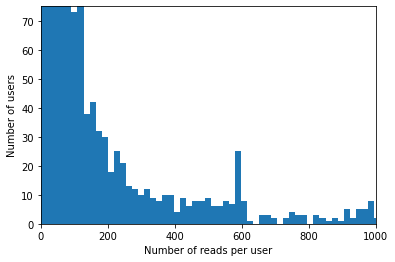

In [19]:
duplicate_counts_per_user = df['User_id'].value_counts()
plt.hist(duplicate_counts_per_user, bins = 100)
plt.ylim([0,75])
plt.xlim([0,1000])
plt.xlabel('Number of reads per user')
plt.ylabel("Number of users")
# print(duplicate_counts_per_value)

5464046      1808
52575353      997
2843923       995
80316998      992
4776065       987
3804149       984
2382210       983
3804182       983
2843922       983
13779         982
14006100      978
2843952       975
3837787       972
3804224       970
5525204       967
46972495      960
4776032       955
1526851       953
1031131       952
9497931       951
1031116       941
2843912       928
5887927       927
7953270       919
1718619       918
7844685       917
29254806      908
1157848       907
5015868       896
2228181       882
2947350       870
6561986       868
5015851       842
7871599       837
1113855       817
5817356       815
1113878       815
5525209       793
9246192       792
2040366       789
3837852       773
3857783       772
8590635       764
89793681      758
29254755      754
89100136      751
5464094       744
7871633       741
2369944       735
48727754      697
5464075       690
5073972       682
1031120       675
1113811       674
133546057     669
2040284   

KeyError: '1'

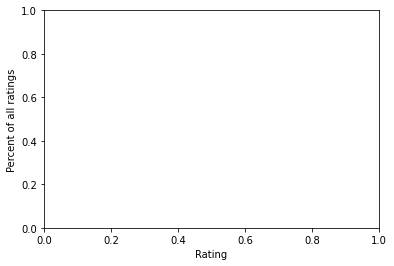

In [20]:
per_rating = df['Rating'].value_counts()
print(duplicate_counts_per_user)
# plt.hist(duplicate_counts_per_user)
# plt.ylim([0,75])
# plt.xlim([0,1000])
plt.xlabel('Rating')
plt.ylabel("Percent of all ratings")
# print(duplicate_counts_per_value)
per_rating_list = np.array([per_rating['1'], per_rating['2'], per_rating['3'], per_rating['4'], per_rating['5']])
total = per_rating_list.sum()
# # plt.plot([1, 2, 3, 4, 5], [per_rating['1'], per_rating['2'], per_rating['3'], per_rating['4'], per_rating['5']])
# plt.bar([1, 2, 3, 4, 5], per_rating_list / total * 100)#, color='skyblue')

print(per_rating_list / total * 100)